In [1]:
import os
import glob
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K
import cv2

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from kAugmentations.kRotation import *
from kAugmentations.kBrightness import *
from kAugmentations.kShearX import *
from kAugmentations.kTranslateX import *
from kAugmentations.kContrast import *

from SingleAugmentationConfig import *
from MultiAugmentationManager import MultiAugmentationManager

import shutil

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

%matplotlib inline

/home/tom/anaconda3/envs/DADA/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_configs = [contrast_config, brightness_config, translateX_config, rotation_config]
# ma_manager = MultiAugmentationManager([contrast_config, translateX_config])
ma_manager = MultiAugmentationManager([brightness_config, rotation_config])
# ma_manager = MultiAugmentationManager([contrast_config, brightness_config, rotation_config])
# ma_manager = MultiAugmentationManager([contrast_config, brightness_config, rotation_config, translateX_config])




In [3]:
figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{ma_manager.run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{ma_manager.run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)
os.makedirs(f'{run_figures_dir}/learning_progress', exist_ok=True)

In [4]:
batch_size = 64
epochs = 1
early_stopping = 1000

criterion_constructor = nn.MSELoss
criterion_constructor_args = {}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    ma_manager.get_target_augmentations()
])

target_transform = transforms.Compose([
    # transforms.ToTensor(),
    target_augmentations
])

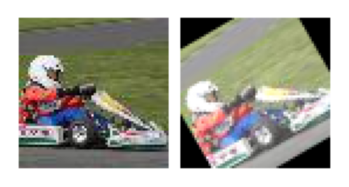

In [6]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)
show_sample(dataset[0])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
model = ma_manager.get_augmentations_model()
model.to(device)

ImageSequential(
  (kBrightness_0): kBrightness()
  (kRotation_1): kRotation()
)

In [8]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

kBrightness_0.trans_param tensor([0.], device='cuda:0')
kRotation_1.trans_param tensor([0.], device='cuda:0')


In [9]:
criterion = criterion_constructor(**criterion_constructor_args)
ma_manager.init_optimizers(model)
ma_manager.init_schedulers()

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e+02.


In [10]:
with torch.no_grad():
    img_dict = {
        "source": dataset[0][0],
        "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
        "target": dataset[0][1]
    }
    learning_grid(img_dict, title=ma_manager.grid_title,
                  save=f'{run_figures_dir}/learning_progress/epoch-{0:02}_batch-{0:05}.png')
    
ma_manager.init_params_progress()
ma_manager.update_params_progrogress(model)

In [11]:
losses = []
ma_manager.init_lrs_progress()
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        ma_manager.optimizers_zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        ma_manager.optimizers_step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | ', end='')
            print(f'{ma_manager.get_current_params_str(model)}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0].unsqueeze(0).to(device)).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, title=ma_manager.grid_title,
                              save=f'{run_figures_dir}/learning_progress/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        ma_manager.update_lrs_progrogress()
        ma_manager.update_params_progrogress(model)
        ma_manager.schedulers_step(i)

        if i == early_stopping:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.106 | brightness_factor: 0.102, angle: 22.021]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.038 | brightness_factor: 0.250, angle: 53.856]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.077 | brightness_factor: 0.306, angle: 62.943]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.078 | brightness_factor: 0.287, angle: 52.976]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.036 | brightness_factor: 0.259, angle: 22.897]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.060 | brightness_factor: 0.232, angle: 10.280]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.043 | brightness_factor: 0.216, angle: 34.357]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.043 | brightness_factor: 0.238, angle: 50.303]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.054 | brightness_factor: 0.259, angle: 43.910]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.024 | brightness_factor: 0.264, angle: 19.840]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.043 | brightness_factor: 0.249, angle: 23.761]
Adjusting learning rate of group 0 to 9.9978e-03.
Adjusting learning rate of group 0 

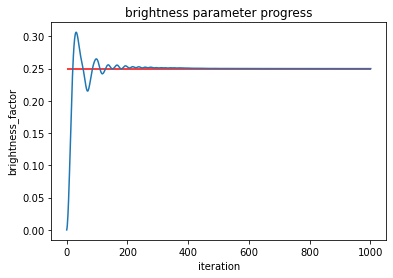

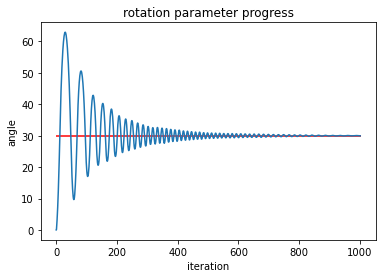

In [12]:
for sa_conf in ma_manager.sa_configs:
    param_progress = ma_manager.params_progress[sa_conf.augmentation_name]
    plt.plot(param_progress, zorder=7)
    plt.hlines(y=sa_conf.target_param_val, xmin=0, xmax=[len(param_progress)], color='r',zorder=5)
    plt.xlabel('iteration')
    plt.ylabel(f'{sa_conf.main_parameter_name}')
    plt.title(f'{sa_conf.augmentation_name} parameter progress')
    plt.savefig(f'{run_figures_dir}/results/parameter_progress__{sa_conf.augmentation_name}.png')
    plt.show()

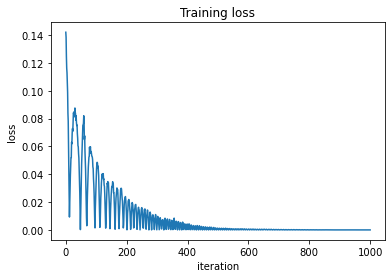

In [13]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

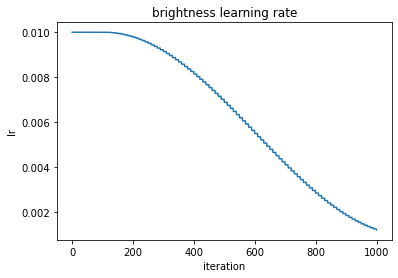

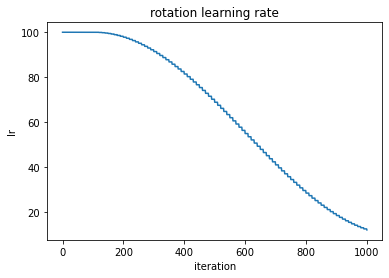

In [14]:
for sa_conf in ma_manager.sa_configs:
    lrs = ma_manager.lrs_progress[sa_conf.augmentation_name]
    plt.plot(lrs)
    plt.title(f'{sa_conf.augmentation_name} learning rate')
    plt.xlabel('iteration')
    plt.ylabel('lr')
    plt.savefig(f'{run_figures_dir}/results/learning_rate__{sa_conf.augmentation_name}.png')
    plt.show()

In [15]:
num_frames = 1000
start_freeze_frames = 80
# filepaths
fp_in = f"{run_figures_dir}/learning_progress/epoch-*"
fp_out = run_gif_name

img_list = [Image.open(f) for f in sorted(glob.glob(fp_in))][:num_frames]
img_list = [img_list[0]]*start_freeze_frames + img_list
imgs = iter(img_list)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=7.5, loop=0)

In [16]:
# with torch.no_grad():
#     param_losses = []
#     param_space = []
#     for p0 in tqdm(ma_manager.sa_configs[0].param_linspace):
#         for p1 in tqdm(ma_manager.sa_configs[1].param_linspace):
#             p_model = K.augmentation.ImageSequential(
#                 ma_manager.sa_configs[0].kAugmentation(init_param=p0),
#                 ma_manager.sa_configs[1].kAugmentation(init_param=p1)
#             )
#             for i, data in enumerate(dataloader): # calc for one batch
#                 source_images, target_images = data
#                 source_images, target_images = source_images, target_images
#                 output_images = p_model(source_images)
#                 loss = criterion(output_images, target_images)
#                 param_losses.append(loss.item())
#                 param_space.append((p0,p1))
#                 break
#     param_losses = np.array(param_losses)

# # param_progress_idxs = []
# # for p in param_progress:
# #     idx_dist = np.apply_along_axis(lambda idx: abs(idx - p), axis=0, arr=param_linspace)
# #     param_progress_idxs.append(np.argmin(idx_dist))
# 
# np_param_space = np.array(param_space)
# np_param_losses = param_losses
# 
# np.save('experiments/np_param_space', np_param_space)
# np.save('experiments/np_param_losses', param_losses)

In [17]:
np_param_space = np.load('experiments/np_param_space.npy')
np_param_losses = np.load('experiments/np_param_losses.npy')

In [18]:
# %matplotlib qt5

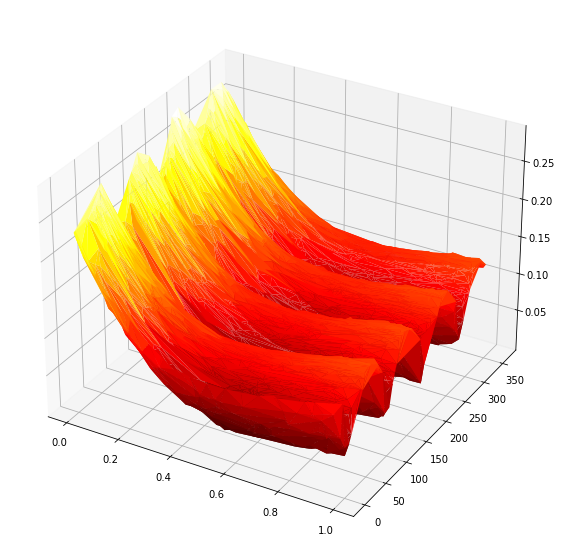

In [21]:
plt.figure(1, figsize=(10,10))
jump=10
random_idxs = np.random.permutation(len(np_param_losses))[::jump]
x,y,z = np_param_space[random_idxs,0], np_param_space[random_idxs,1], np_param_losses[random_idxs]
ax = plt.axes(projection='3d')
ax.plot_trisurf(x,y,z, cmap='hot', edgecolor='none')
plt.show()

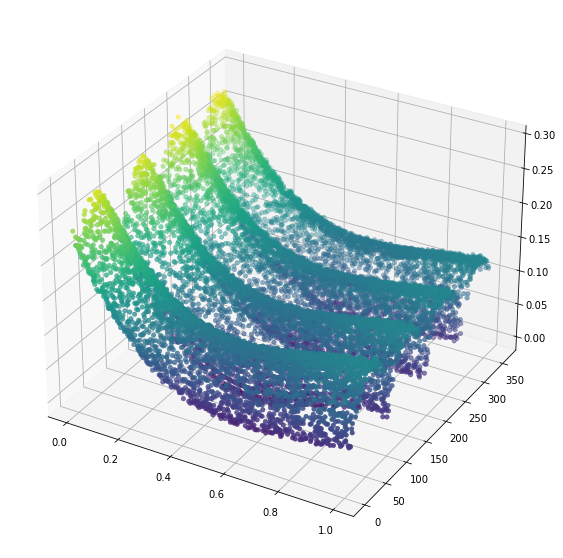

In [22]:
plt.figure(2, figsize=(10,10))
jump=3
# x,y,z = np_param_space[::jump,0], np_param_space[::jump,1], np_param_losses[::jump]
random_idxs = np.random.permutation(len(np_param_losses))[::jump]
x,y,z = np_param_space[random_idxs,0], np_param_space[random_idxs,1], np_param_losses[random_idxs]
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);
plt.show()